In [15]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from lib.prepare_data import prepare_dataset
from lib.show import show_hyperparam_opti
from lib.train import iterate_params, choose_params, nb_possibility
from lib.prepare_data import make_cut, to_categorical

In [16]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [17]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_tremi_old.csv",
        "name": "pred_tremi_full",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [18]:
# name the important datasets and cast to type
training_tremi = dataframes["pred_tremi_full"].withColumns(
    {
        "surface": F.col("surface").cast("int"),
        "heating_production": F.col("heating_production").cast("int"),
    }
)

dictionary = dataframes["dictionary"]

In [19]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col("surface").isNotNull()).drop(
    "heating_production", "heating_emission"
)

# ML

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [24]:
# choose best cuts
col_X_hot = []
col_y = ["surface"]
col_X_not_hot = [
    col[0] for col in training_surf.dtypes if col[0] not in col_X_hot + col_y
]

# same model to compare every score
param = {"C": 6.522117123602399, "class_weight": "balanced", "max_iter": 1000}
model = LogisticRegression(**param)

# different cuts to try
cut_params = {
    "first_value": [30, 40, 50, 60, 70],
    "steps": [25, 35, 45, 55, 65],
    "nb_steps": [1, 2, 3],
}

# iterate over all params above
current = [0 for _ in range(len(cut_params))]
max_hyper = [len(cut_param) - 1 for cut_param in cut_params.values()]
current_params = choose_params(current, cut_params)
all_poss = nb_possibility(max_hyper)
print(all_poss)

cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf, "surface", cuts)
X, y, _ = prepare_dataset(
    categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False, True
)
# register score
max_score = np.mean(cross_val_score(model, X, y, cv=4))
best_split = deepcopy(current_params)
scores = {}
coefs = {}
score_corrected = coef * max_score
coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
scores[tuple([param for param in current_params.values()])] = deepcopy(score_corrected)

i = 0
nb_print = (all_poss // 4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, cut_params)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    cuts = make_cut(**current_params)
    categorical_surf, coef = to_categorical(training_surf, "surface", cuts)
    X, y, _ = prepare_dataset(
        categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False, True
    )

    # register score
    score_corrected = coef * np.mean(cross_val_score(model, X, y, cv=4))
    scores[tuple([param for param in current_params.values()])] = deepcopy(
        score_corrected
    )
    coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
    if score_corrected > max_score:
        max_score = deepcopy(score_corrected)
        best_split = deepcopy(current_params)

75
0 [1, 0, 0]
19 [0, 4, 0]
38 [4, 2, 1]
57 [3, 1, 2]


In [67]:
def to_string(*param_cuts):
    cuts = make_cut(*param_cuts)
    return_array = []
    for i, cut in enumerate(cuts):
        if i == len(cuts) - 1:
            return_array.extend([f"<{cut}", f">{cut}"])
        else:
            return_array.append(f"<{cut}")
    return return_array

# format cuts to be more readable
scores_string = {
    tuple(key): value
    for key, value in zip(map(lambda x: to_string(*x), scores), scores.values())
}

Text(0.5, 0, 'classes')

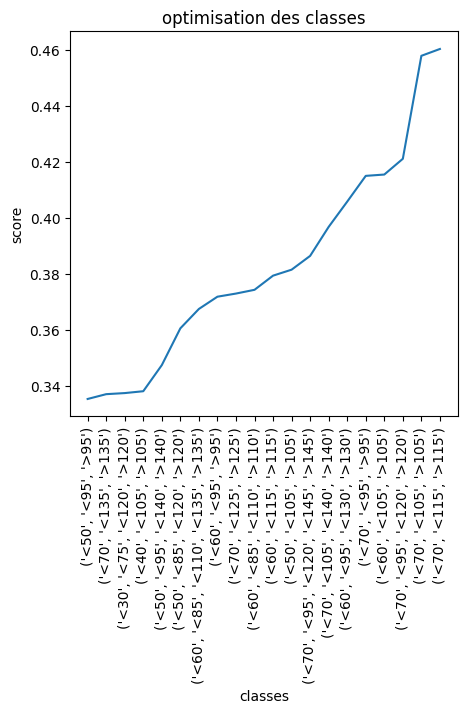

In [68]:
# plot 20 best cuts
f, ax_hyper = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
# show_hyperparam_opti(coefs, cut_params, ax_hyper, 'surface_split')
x_pos = [i for i in range(20)]
scores_string = dict(sorted(scores_string.items(), key=lambda x: x[1]))
ax_hyper.plot(x_pos, list(scores_string.values())[-20:])
ax_hyper.set_xticks(x_pos, labels=list(scores_string.keys())[-20:], rotation=90)
ax_hyper.set_title(f"""{'optimisation des classes'}""")
ax_hyper.set_ylabel("score")
ax_hyper.set_xlabel("classes")